In [1]:
from orbitflows import HamiltonianMappingModel, generate_sho_orbits
import matplotlib.pyplot as plt
import numpy as np
import torch
from orbitflows import H, H_sho, actionAngleHarmonic, actionAngleHarmonicInverse
from orbitflows.integrate import eulerstep, rungekutta4
from time import time
from functools import partial
from tqdm import tqdm

In [2]:
n_actions = 1
n_angles = 100
r_min = 0.5
r_max = 1.5
omega_guess = 1
omega_correct = 1.5
prediction, aa_guess = generate_sho_orbits(n_actions, omega=omega_guess, t_end=10, n_steps=n_angles, r_bounds=[r_min*1.0,r_max*1.0]) 
correct_ps, correct_aa = generate_sho_orbits(n_actions, omega=omega_correct, t_end=10, n_steps=n_angles, r_bounds=[r_min,r_max])

In [3]:
H_toy = partial(H_sho, omega=omega_guess)
H_correct = partial(H_sho, omega=omega_correct)

In [5]:
def aa_to_ps(aa):
    '''
    Convert action-angle coordinates to phase-space coordinates under "learned" transformation.
    
    Parameters
    ----------
    aa : torch.tensor
        action-angle coordinates
    
    Returns
    -------
    torch.tensor
        phase-space coordinates
    '''
    theta, j = aa[..., 0], aa[..., 1]
    q, p = actionAngleHarmonicInverse(omega=omega_guess)(j, theta)
    ps = torch.stack((q, p), dim=-1)
    return ps

def ps_to_aa(ps):
    '''
    Convert phase-space coordinates to action-angle coordinates under "learned" transformation.
    '''
    q, p = ps[..., 0], ps[..., 1]
    j, _, theta = actionAngleHarmonic(omega=omega_guess).actionsFreqsAngles(q, p)
    aa = torch.stack((theta, j), dim=-1)
    return aa

In [6]:
def model_hamiltonian(aa):
    theta, j = aa[..., 0], aa[..., 1]
    q, p = actionAngleHarmonicInverse(omega=omega_guess)(j, theta)
    ps = torch.stack((q, p), dim=-1)
    return H_sho(ps, omega=omega_correct)

In [7]:
def hamiltonian_fixed_angle(aa, theta_set=torch.tensor(0.0)):
    '''
    Compute the Hamiltonian at an action, averaged over angles.
        
    Parameters
    ----------
    aa : torch.tensor
        action-angle variables

    theta_set : torch.tensor
        angle to be set in the Hamiltonian.
        
    Returns
    -------
    torch.tensor
        Hamiltonian averaged over the angle
    '''
    _aa = aa.clone()
    _aa[..., 0] = theta_set.clone()
    return model_hamiltonian(_aa)

In [8]:
def integrate(aa, steps, t_end, correction=eulerstep, hamiltonian_tilde=hamiltonian_fixed_angle):
        '''Routine to integrate orbits in AA space and update frequencies regularly, with euler step correction
    
        Parameters
        ----------
        aa : torch.tensor
            initial action-angle variables

        steps : int
            number of steps in action-angle space between frequency updates

        t_end : float
            end time of the integration
        
        correction : callable
            correction function to be used in the integration process.
            Should take the phase-space coordinates, the time step, and the hamiltonian_tilde
            function as arguments.
            The function should return new phase-space coordinates of the same shape as the input.

        hamiltonian_tilde : callable
            Assumption for the correct Hamiltonian as a function of action-angle variables.
            Only arguments should be model and aa, so it's recommended to use a partial function or
            redefine the function such that this is the case.
        
        Returns
        -------
        torch.tensor
            action-angle variables as a function of time
        
        '''

        def _hamiltonian_error(ps):
            '''
            Compute the error of the model prediction in the Hamiltonian.
            
            Parameters
            ----------
            ps : torch.tensor
                phase-space point
            
            Returns
            -------
            torch.tensor
                Hamiltonian error of the model prediction
            '''
            _aa = ps_to_aa(ps)
            return H_sho(ps, omega = omega_correct) - hamiltonian_tilde(_aa)

        def _freq_tilde(aa):
            '''
            Compute the frequency of the system using the hamiltonian_tilde function.
            
            Parameters
            ----------
            aa : torch.tensor
                action-angle variables

            Returns
            -------
            torch.tensor
                frequency of the system assuming the hamiltonian_tilde function
            '''
            theta, j = aa[..., 0], aa[..., 1]
            _aa = torch.stack((theta, j), dim=-1)
            return torch.autograd.grad(hamiltonian_tilde(_aa), j, allow_unused=True)[0]
        
        delta_t = torch.tensor(t_end/steps)
        theta_list = torch.zeros(steps)
        j_list = torch.zeros(steps)
        
        theta0 = aa[...,0]
        j0 = aa[...,1]
        freq = _freq_tilde(aa)
        

        for i, t in enumerate(tqdm(torch.linspace(0, t_end, steps))):
            # evolve in action-angle space
            theta_half = theta0 + freq*delta_t/2 # drift 

            # transform to phase space
            aa_half = torch.stack((theta_half, j0))
            ps_half = aa_to_ps(aa_half)

            # compute Hamiltonian error

            ps_half_corrected = correction(ps_half, delta_t, _hamiltonian_error)

            # convert back to action-angle space
            aa_half_corrected = ps_to_aa(ps_half_corrected)

            # update frequency
            theta_half_corrected = aa_half_corrected[0]
            j = aa_half_corrected[1]
            freq = _freq_tilde(aa_half_corrected)

            # drift
            theta = theta_half_corrected + freq*delta_t/2

            theta_list[i] = theta
            j_list[i] = j
            theta0 = theta
            j0 = j
            #print(theta0, J0)
        return torch.stack([theta_list, j_list], dim=-1)

In [9]:
# check out what happens if I pick a different angle -- it clearly fits a torus in the correct potential through the point you choose to start at in phase space of the guess potential
aa_out_euler = integrate(torch.tensor(aa_guess[0][0], requires_grad=True), 100, 10, correction=eulerstep)
aa_out_rk4 = integrate(torch.tensor(aa_guess[0][0], requires_grad=True), 100, 10, correction=rungekutta4)

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_19255/3226473679.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_out_euler = integrate(torch.tensor(aa_guess[0][0], requires_grad=True), 100, 10, correction=eulerstep)



100%|██████████| 100/100 [00:00<00:00, 780.43it/s]


/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_19255/3226473679.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aa_out_rk4 = integrate(torch.tensor(aa_guess[0][0], requires_grad=True), 100, 10, correction=rungekutta4)



100%|██████████| 100/100 [00:00<00:00, 251.31it/s]


In [10]:
ps_out_euler = aa_to_ps(aa_out_euler)
ps_out_rk4 = aa_to_ps(aa_out_rk4)

In [11]:
ps_out_euler - ps_out_rk4

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.000

(np.float64(-0.5499770000576973),
 np.float64(0.5499989047646523),
 np.float64(-0.8256368547677994),
 np.float64(0.825372388958931))

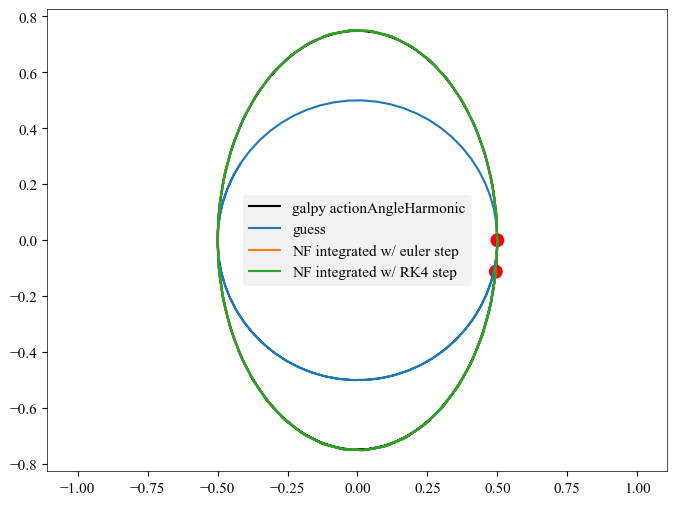

In [12]:
plt.plot(correct_ps[0][..., 0], correct_ps[0][..., 1], label='galpy actionAngleHarmonic')
plt.plot(prediction[0][..., 0], prediction[0][..., 1], label='guess')
plt.plot(ps_out_euler[..., 0].detach(), ps_out_euler[..., 1].detach(), label='NF integrated w/ euler step')
plt.plot(ps_out_rk4[..., 0].detach(), ps_out_rk4[..., 1].detach(), label='NF integrated w/ RK4 step')
plt.scatter(ps_out_euler[..., 0].detach()[0], ps_out_euler[..., 1].detach()[0], s=100, c='red')
plt.scatter(correct_ps[..., 0].detach()[0][0], correct_ps[..., 1].detach()[0][0], s=100, c='red')

plt.legend()
plt.axis('equal')

In [14]:
# plt.plot(aa_out_euler.detach()[:,1])
# plt.plot(aa_out_rk4.detach()[:,1])

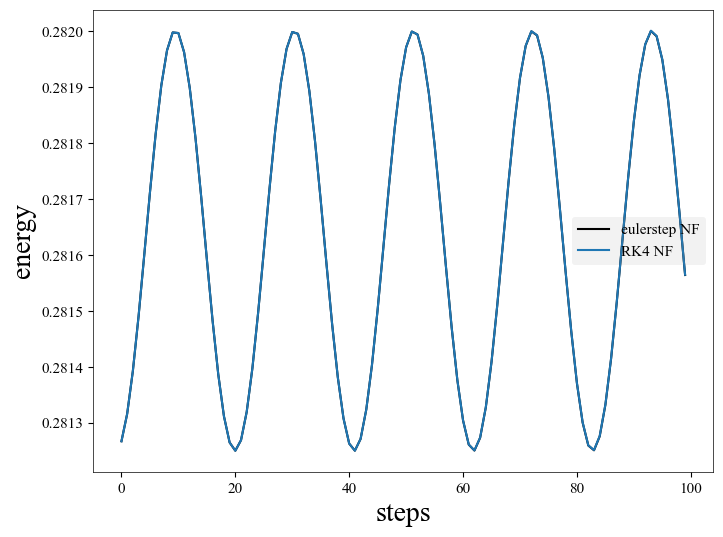

In [15]:
plt.plot(H_sho(ps_out_euler, omega=omega_correct).detach(), label='eulerstep NF')
plt.plot(H_sho(ps_out_rk4, omega=omega_correct).detach(), label='RK4 NF')
#plt.plot(H_sho(prediction[0], omega=omega_correct).detach(), label='guess')
#plt.plot(H_sho(correct_ps[0], omega=omega_correct).detach(), label='galpy integrated')
plt.xlabel('steps', fontsize=20)
plt.ylabel('energy', fontsize=20)
plt.legend()

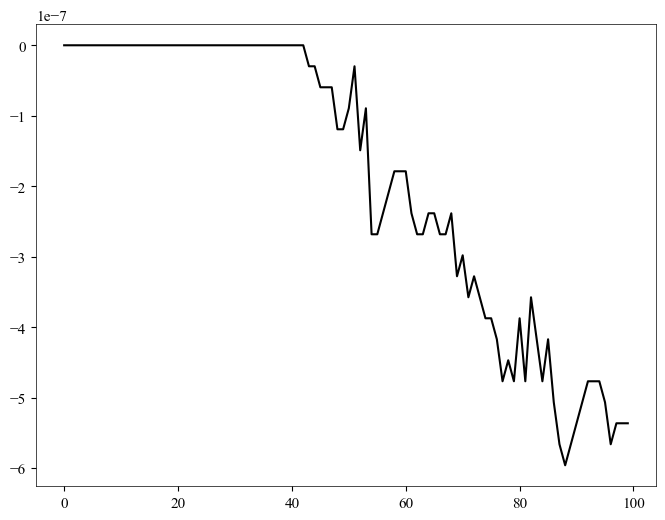

In [16]:
plt.plot((H_sho(ps_out_euler, omega=omega_correct) - H_sho(ps_out_rk4, omega=omega_correct)).detach())